# 05 - Support Vector Machines

Capable of linear or nonlinear classification, regression, and outlier detection. Most often applied to classification for complex small-medium datasets.

In [1]:
# -- Setup -- #
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Linear SVM Classification

In [6]:
# -- Generate Figures, Ignore --#
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y);

Saving figure large_margin_classification_plot


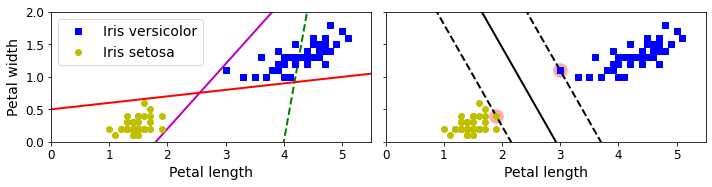

In [7]:
# -- Generate Figures, Ignore --#

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

Example above based on Iris dataset is **linearly seperable**. On left, decision boundaries unlikely to perform well with new data. SVM **large margin classifier** on right, give margin, better model. Adding more training instances "off the street" does not change decision boundary as it is fully supported by instances located on the edge, i.e. **support vectors**. 

Saving figure sensitivity_to_feature_scales_plot


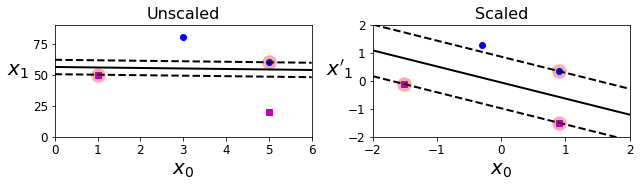

In [4]:
# -- Generate Figures, Ignore --#

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

Above we see the support vectors as well as the sensitivity of scaling on the decision boundary. (Scaling should be perfomed).

### Soft Margin Classification

Saving figure sensitivity_to_outliers_plot


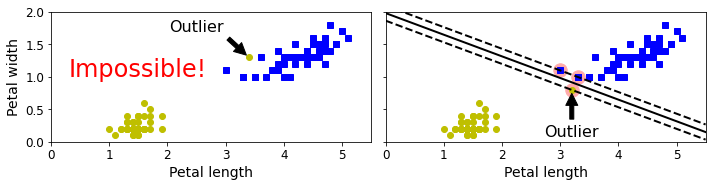

In [5]:
# -- Generate Figures, Ignore --#

X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

## Nonlinear SVM Classification

### Polynomial Kernel

### Similarity Features

### Gaussiean RBF Kernel

### Computational Complexity

## SVM Regression

## Under the Hood 

### Decision Function and Predictions

### Training Objective

### Quadratic Programming

### The Dual Problem

### Kernelized SVMs

### Online SVMs